<a href="https://colab.research.google.com/github/nickhward/Tweets_and_bitcoin/blob/main/sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Goal**
- Achieve accurate sentiment analysis on the tweets
- Create a machine learning model that can predict price changes of Bitcoin from tweets in the current day, week, or month

# **GOAL OF THIS NOTEBOOK**

- To find derive information from the bitcoin dataset
- To clean the dataset to get ready for modeling
- Sentiment analysis on each tweet using tensorflow
- The features I come up with here will be used in another notebook that will include the bitcoin price data ['open', 'low', 'close', 'high', 'volume']
- Since this dataset is so large, and I don't want to pay for google pro + ( I have google pro) I will be using a method of chunking the data so that I reduce the memory usage. 
 - The reason this reduces memory as only one chunk is kept in memory at any time 



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

import nltk
from nltk.corpus import stopwords


In [ ]:

# the reason I'm using with open instead of pd.read_csv is due to a parser error
# that read_csv can't seem to handle
# The built in csv reading library is more flexible thatn pandas when 
# reading malformed CSV files. 
# need to load in the data like this to save on notebook memory. Cuts the memory
# usage in half. 
from itertools import islice

def process_chunk(chunk):
    # Convert columns to numeric, coerce errors to NaN
    chunk['user_followers'] = pd.to_numeric(chunk['user_followers'], errors='coerce')
    chunk['user_friends'] = pd.to_numeric(chunk['user_friends'], errors='coerce')

    # Remove rows with NaN in 'user_followers' and 'user_friends'
    chunk = chunk.dropna(subset=['user_followers', 'user_friends'])

    return chunk[['user_followers', 'user_friends', 'user_verified', 'date', 'text']]

chunk_size = 200_000  # Define your chunk size
chunks = []

with open('/content/drive/MyDrive/Bitcoin_tweets.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # get the header

    while True:
        data = list(islice(reader, chunk_size))
        if not data:
            # no more data to read
            break

        chunk = pd.DataFrame(data, columns=header)
        chunks.append(process_chunk(chunk))  # process your data here

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, axis=0)
del chunks

In [ ]:
#remove people that have most likely no influence and are probably bots
print(df.shape)
df = df[df['user_followers'] > 5_000]

(4689336, 5)


In [ ]:
print(df.shape)

(579296, 5)


# **Understanding the Data**

In [ ]:
print(df.columns)
print(df.shape)
df.head()


Index(['user_followers', 'user_friends', 'user_verified', 'date', 'text'], dtype='object')
(579296, 5)


,user_followers,user_friends,user_verified,date,text
0,8534.0,7605.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,6769.0,1532.0,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
9,8534.0,7605.0,False,2021-02-10 23:52:08,.@Tesla’s #bitcoin investment is revolutionary...
12,5097.0,791.0,False,2021-02-10 23:50:59,Join our first virtual crypto meetup of 2021 -...
16,72542.0,519.0,False,2021-02-10 23:48:37,@naval #BTC is unconfiscatable \n\nAll roads l...


**We are given the following features**

* user name
* user location
* user description
* user created
* user followers
* user friends
* user favourites
* user verified
* date
* text
* hashtags
* source
* is retweet

Right off the bat I can garuntee that user name, location, description, user created, and user favourites, and source will not help me in this problem. I will be dropping from the the dataset


# **Lets see how dirty the text column is**

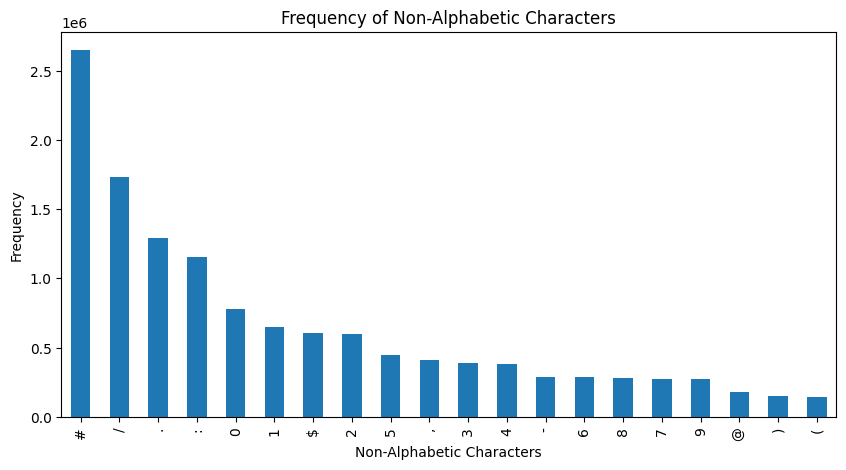

In [ ]:
# seeing what the frequency of non alphabetic characters in the dataset

# extract non-alphabetic characters
non_alpha = df['text'].str.extractall(r'([^A-Za-z\s])')[0]

# count the occurrence of each non-alphabetic character
# limit to the top 20 because the chart will be extremely crowded due to so many
# unique characters
counts = non_alpha.value_counts().nlargest(20)

# create a bar plot
plt.figure(figsize=(10, 5))
counts.plot(kind='bar')
plt.title('Frequency of Non-Alphabetic Characters')
plt.xlabel('Non-Alphabetic Characters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# download the stopwords and punkt (used for tokenization) from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# get the English stopwords
stop_words = set(stopwords.words('english'))

# tokenize the words in text column
words = df['text'].apply(word_tokenize).explode()

# filter out the stopwords
stop_words_in_text = words[words.isin(stop_words)]

# get the frequencies of each stopword
stop_word_counts = Counter(stop_words_in_text)

# print the most common stopwords
print(stop_word_counts.most_common())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('the', 290846), ('to', 226067), ('and', 158419), ('is', 147097), ('a', 136675), ('of', 133773), ('in', 115672), ('for', 103818), ('on', 102711), ('you', 68255), ('this', 58193), ('it', 57854), ('with', 53680), ('will', 50142), ('at', 48209), ('that', 44917), ('be', 44609), ('are', 43745), ('by', 43119), ('has', 41594), ('from', 40788), ('your', 34398), ('as', 33176), ('we', 28396), ('now', 27803), ('s', 27443), ('more', 25950), ('have', 25351), ('not', 24404), ('can', 22704), ('or', 21944), ('all', 20977), ('about', 20921), ('up', 20679), ('my', 20614), ('do', 18966), ('out', 18818), ('but', 18609), ('an', 17543), ('very', 15618), ('just', 15516), ('our', 15014), ('its', 14802), ('was', 14740), ('here', 14734), ('if', 14272), ('over', 13299), ('t', 12370), ('so', 12336), ('what', 12332), ('than', 11923), ('they', 11618), ('their', 11124), ('me', 10569), ('how', 9627), ('when', 9377), ('only', 9318), ('some', 9153), ('down', 8791), ('below', 8744), ('into', 8645), ('been', 8595), ('no

Some words I noticed in the stop words that shouldn't be taken out because it could help our model with sentiment analysis. 

In [ ]:
stopwords_to_keep = [
    'wont',
    'isnt',
    'havent', 
    'up',
    'no',
    'should',
    'wouldn',
    'shouldn',
]

# remove the listed words from the stop words list so we don't remove them
stop_words = [word for word in stop_words if word not in stopwords_to_keep]

# Define a function to remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words or ('http' not in word)]
    return ' '.join(filtered_text)

# get rid of all punctuation, The regular expression '[^\w\s]' matches any 
# character that is not a word character (represented by \w) or a whitespace 
# character (represented by \s). Therefore, this line of code replaces all 
# punctuation characters with an empty string.

df['text'] = df['text'].str.replace('[^\w\s]', '')


# Getting rid of stop words
df['text_no_stop'] = df['text'].apply(lambda x : remove_stopwords(x))

df.head()

In [ ]:
# Checking for rare words

# tokenize the words in your column
words = df['text_no_stop'].apply(word_tokenize).explode()

# get the frequencies of each word
word_counts = nltk.FreqDist(words)

# get words that occur only once or twice
rare_words = {word: count for word, count in word_counts.items() if count <= 2}




In [ ]:
# Print the first 10 items in the dictionary
print(list(rare_words.items())[:100])
print(len(rare_words))


In [ ]:
import re

#function to remove URLs with regular expressions
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', text)
    return no_url

#funciton to remove emails with regular expression
def remove_emails(text):
    email_pattern = re.compile(r'\S+@\S+')
    no_email = email_pattern.sub(r'', text)
    return no_email


df['cleaned_text'] = df['text_no_stop'].apply(lambda x : remove_urls(x))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_emails(x))



In [ ]:
!pip install langdetect

In [ ]:
# One thing I noticed with this dataset is that some of the language is not in 
# english so I will want to remove this as well as I don't want to deal with 
# none english entries for now.

# we are lucky again there is already a curated library that will detect english 
# for us.

from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['is_english'] = df['cleaned_text'].apply(lambda x : is_english(x))


In [ ]:
#take out all non english rows
df_final = df[df['is_english'] == True]
#Since we don't need the is_english column anymore remove it from dataframe
df_final.drop(columns=['is_english'])

Unfortunately this dataset does not come with sentiment labels. We will need to up with semtiment ourselves. Luckily there are libraries out there like VADER or TextBlob:
- **TextBlob:** calculates sentiment by looking at each word individually, using a predefined list of words that have been manually annotated with their polarity and subjectivity scores. Because of this, TextBlob can sometimes fail to accurately determine the sentiment of sentences that rely on context or have more complex structures.
- **VADER:** on the other hand, takes into account not just individual words, but also the context around them. It considers factors like capitalization, punctuation, and word order. This makes it better suited to handling more complex, nuanced sentiment analysis, and it's particularly well-tuned for social media text, where such context is often important.

In [ ]:
# pip install vaderSentiment
!pip install vaderSentiment

In [ ]:
# I will be using VADER for this case because context, capitalization and word 
# will most likely be important for this project
# pos: The probability of the sentiment being positive.
# neu: The probability of the sentiment being neutral.
# neg: The probability of the sentiment being negative.
# compound: The compound score of the sentiment that's 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def apply_vader(text):
    sentiment = analyzer.polarity_scores(text)
    return pd.Series([sentiment['pos'], sentiment['neu'], sentiment['neg'], sentiment['compound']])

df[['pos', 'neu', 'neg', 'compound']] = df['text_no_stop'].apply(apply_vader)



In [ ]:
# Assuming you have 'pos', 'neu', and 'neg' columns in your df
plt.hist(df['compound'], bins=20, alpha=0.5, label='Compound')
plt.hist(df['pos'], bins=20, alpha=0.5, label='Positive')
plt.hist(df['neg'], bins=20, alpha=0.5, label='Negative')
plt.hist(df['neu'], bins=20, alpha=0.5, label='Neutral')

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of VADER Sentiment Scores')
plt.legend(loc='upper right')
plt.show()

In [ ]:
df.head()

In [ ]:
# save dataframe as a feather file 
df.reset_index()
df.to_csv('cleaned_bitcoin_tweet_data.csv')

In [ ]:
df.shape